In [1]:
%load_ext autoreload
%autoreload 2

In [101]:
from model import AutoEncoder_gnnrnn
from data import prepare_data_vocab, live_feat, batch_gnn_for_gpu, split_pp_into_sublists, split_train_test, count_occurrences
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [98]:
word_to_idx, idx_to_word, data, data_emb = prepare_data_vocab("data", func=live_feat, function_num=0)

In [279]:
bidir          = False
dir            = 2 if bidir else 1 
batch_size     = 64
num_layers_enc = 3
hidden_dim_enc = 32
num_layers_dec = 3
hidden_dim_dec = 32
emb_dim        = 32
N_max          = len(word_to_idx)+1
layer_dims_gnn = [16, 32, 16]

dataset = split_pp_into_sublists(data_emb, batch_size)
(train, test) = split_train_test(dataset)

ae = AutoEncoder_gnnrnn(batch_size     = batch_size,
            bidir          = True,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            layer_dims_gnn = layer_dims_gnn,
            emb_dim        = emb_dim,
            N_max          = N_max)

if torch.cuda.is_available():
    device = torch.device("cuda")  # Or "cuda:0" for the first GPU
else:
    device = torch.device("cpu")

#device = torch.device("cpu")
ae.to(device)


train_gpu = batch_gnn_for_gpu(train, device, len(word_to_idx))
test_gpu = batch_gnn_for_gpu(test, device, len(word_to_idx))
weight = count_occurrences(train, word_to_idx, device)


criterion = nn.CrossEntropyLoss(ignore_index=len(word_to_idx), weight=weight)
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 
optimizer = optim.Adam(ae.parameters(), lr=0.01)

In [280]:
epoch_num = 100
loss_train = []
accu_train = []
loss_test = []
accu_test = []
for epoch in range(epoch_num):
    total_loss = 0
    j = 0
    cntBatch = 0
    for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
        cntBatch += 1
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="mix", ratio=0.5, ratio_mix=0.5)
        #print(out[:,-1,:])
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        j += np.sum(lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%5==0 or (epoch+1)==epoch_num:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\n')
        cntBatch_test = 0
        total_loss_test = 0
        j_test = 0
        for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
            j_test += np.sum(lengths)
            cntBatch_test += 1
            out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=1)
            loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
            total_loss_test  += loss.item()
        loss_test.append(total_loss_test/cntBatch_test)
        accu_test.append(np.exp(-total_loss_test/cntBatch_test)*100)
        print(f'For {j_test} Tokens List in Test set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss_test/cntBatch_test:.5f}, Acuuracy: {np.exp(-total_loss_test/cntBatch_test)*100:.5f}', end='\n')
        print("-----------------------------------------------------------------------------------")
    else:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\r')
    loss_train.append(total_loss/cntBatch)
    accu_train.append(np.exp(-total_loss/cntBatch)*100)

For 53944 Tokens List in Train set: Epoch 1/100, Average Loss: 2.76769, Acuuracy: 6.28070
For 13779 Tokens List in Test set: Epoch 1/100, Average Loss: 2.86874, Acuuracy: 5.67703
-----------------------------------------------------------------------------------
For 53944 Tokens List in Train set: Epoch 6/100, Average Loss: 1.57525, Acuuracy: 20.69563
For 13779 Tokens List in Test set: Epoch 6/100, Average Loss: 3.67638, Acuuracy: 2.53145
-----------------------------------------------------------------------------------
For 53944 Tokens List in Train set: Epoch 11/100, Average Loss: 1.46615, Acuuracy: 23.08133
For 13779 Tokens List in Test set: Epoch 11/100, Average Loss: 3.24635, Acuuracy: 3.89158
-----------------------------------------------------------------------------------
For 53944 Tokens List in Train set: Epoch 16/100, Average Loss: 1.31586, Acuuracy: 26.82424
For 13779 Tokens List in Test set: Epoch 16/100, Average Loss: 3.28832, Acuuracy: 3.73165
-------------------------

KeyboardInterrupt: 

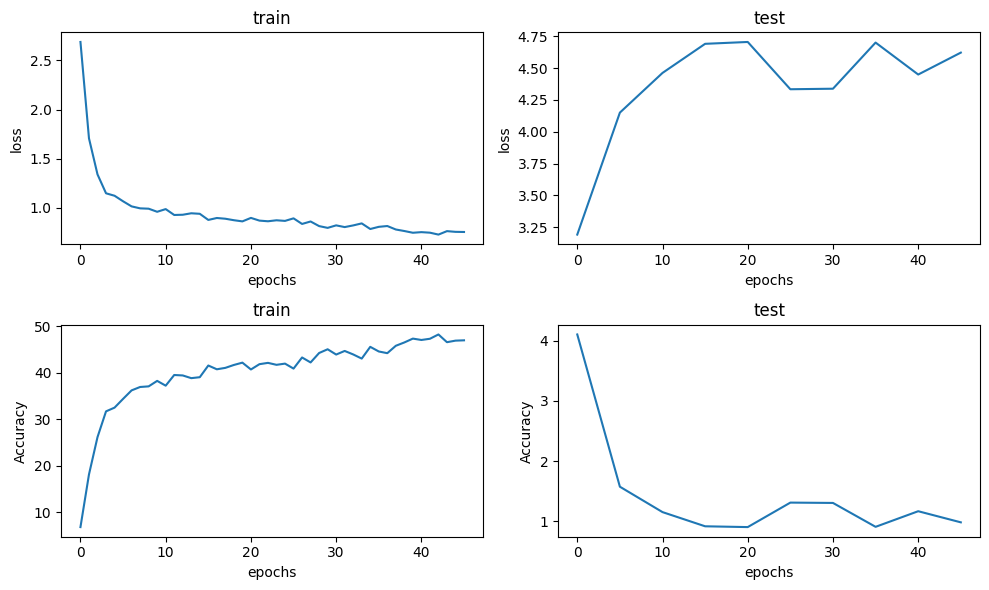

In [231]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10,6)) 
x = [i*5 for i in range(len(accu_test))]
axs[0,0].plot(loss_train)
axs[0,0].set_ylabel("loss")
axs[0,0].set_xlabel("epochs")
axs[0,0].set_title("train")
axs[1,0].plot(accu_train)
axs[1,0].set_ylabel("Accuracy")
axs[1,0].set_xlabel("epochs")
axs[1,0].set_title("train")
axs[0,1].plot(x, loss_test)
axs[0,1].set_ylabel("loss")
axs[0,1].set_xlabel("epochs")
axs[0,1].set_title("test")
axs[1,1].plot(x, accu_test)
axs[1,1].set_ylabel("Accuracy")
axs[1,1].set_xlabel("epochs")
axs[1,1].set_title("test")
plt.tight_layout()
plt.savefig('AE_result.png')

In [282]:
for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="mix", ratio=1, ratio_mix=1)
    pred = out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist()
    actu = padded_seq.flatten().to("cpu").tolist()
    pred_f = []
    actu_f = []
    for i in range(len(actu)):
        if (actu[i]!=40):
            pred_f.append(pred[i])
            actu_f.append(actu[i])
    print("pred:", *pred_f, sep='\t')
    print("actu:", *actu_f, sep='\t')
    print("----------------------------------------------------------------------------------------")
    break
for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="teaching", ratio=1, ratio_mix=1)
    pred = out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist()
    actu = padded_seq.flatten().to("cpu").tolist()
    pred_f = []
    actu_f = []
    for i in range(len(actu)):
        if (actu[i]!=40):
            pred_f.append(pred[i])
            actu_f.append(actu[i])
    print("pred:", *pred_f, sep='\t')
    print("actu:", *actu_f, sep='\t')
    print("----------------------------------------------------------------------------------------")
    break

pred:	8	28	8	8	8	8	8	28	25	23	8	36	8	28	8	28	25	25	3	23	8	36	28	24	25	8	28	25	24	8	36	25	25	2	23	8	36	28	24	25	8	28	25	24	8	36	25	25	2	23	8	36	28	24	25	8	28	9	11	14	32	9	11	14	32	9	11	8	32	9	11	8	32	9	11	14	32	9	11	14	32	8	32	32	9	11	8	28	8	8	8	8	8	28	25	23	8	36	8	28	8	28	25	25	3	23	8	36	28	24	25	8	28	25	24	8	36	8	28	8	8	28	25	23	8	36	25	25	3	23	8	28	24	25	8	28	8	28	25	24	8	36	25	25	3	23	8	8	28	24	25	8	28	25	24	8	28	8	28	8	8	28	25	24	8	28	25	25	3	23	8	28	24	24	8	28	8	28	25	24	8	28	25	25	3	23	8	28	28	24	25	8	28	25	24	8	28	8	28	8	8	28	25	24	8	28	25	25	3	23	8	28	24	24	8	28	8	32	9	11	14	32	9	11	14	32	9	11	14	32	9	11	14	32	9	11	14	32	9	11	14	32	8	32	32	9	11	8	28	28	24	24	8	28	25	25	3	23	8	28	28	25	4	23	8	28	28	24	25	8	28	25	24	8	28	8	28	28	8	28	28	36	25	25	7	23	8	8	8	28	28	8	28	8	8	8	32	32	9	11	8	32	32	9	11	14	32	25	23	8	32	36	25	23	8	32	36	36	25	25	3	23	8	36	8	32	32	8	28	8	25	23	8	36	25	23	8	28	25	24	8	28	8	8	8	8	28	8	8	8	8	28	8	8	8	8	8	8	28	8	8	8	8	8	8	8	25	25	3	23	8	36	36	24	25	8	28	28	8

In [39]:
for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive")
    print("pred:", out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
    print("actu:",padded_seq.flatten().to("cpu").tolist())
    print("----------------------------------------------------------------------------------------")

'2.2.2+cu118'